In [146]:
import torch
import cv2
import imageio
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import save, load
from skimage.metrics import structural_similarity as ssim

## Helper functions

In [122]:
#later add downscale factor for masks
def set_data_path(name, downscale_factor):
    base_path = os.path.join(os.path.abspath(os.path.join(os.getcwd(), os.pardir)), 'data\\nerf_llff_data-20230309T215124Z-001\\nerf_llff_data\\')
    
    mask_dir = os.path.join(base_path, f'{name}\\segmentation_masks\\')
    img_dir = os.path.join(base_path, f'{name}\\images_{downscale_factor}\\')
    
    poses_bounds_dir = os.path.join(base_path, f'{name}\\poses_bounds.npy')
    
    gen_images_dir = os.path.join(base_path, f'{name}\\rendered\\{name}-llff\\')
                                  
    return img_dir, mask_dir, poses_bounds_dir, gen_images_dir



In [123]:
def fetch_data(name, downscale_factor, view=False):
    
    img_dir, mask_dir, poses_bounds_dir, gen_images_dir = set_data_path(name, downscale_factor)
    
    poses_bounds = np.load(poses_bounds_dir)
    
    images = [i for i in sorted(os.listdir(img_dir)) if os.path.isfile(os.path.join(img_dir, i))]
    images = [i for i in images if i.endswith(("JPG", "jpg", "png", "jpeg", "PNG"))]
    
    masks = [i for i in sorted(os.listdir(mask_dir)) if os.path.isfile(os.path.join(mask_dir, i))]
    masks = [i for i in masks if i.endswith(("JPG", "jpg", "png", "jpeg", "PNG"))]
    
    if len(images) != len(masks):
        return 'Number of masks and images do not match.'
    
    gen_images = [i for i in sorted(os.listdir(gen_images_dir)) if os.path.isfile(os.path.join(gen_images_dir, i))]
    gen_images = [i for i in gen_images if i.endswith(("JPG", "jpg", "png", "jpeg", "PNG"))]
    
    
    if view:
        idx = np.random.randint(0, len(images))

        image = cv2.imread(img_dir + images[idx])
        mask = cv2.imread(mask_dir + masks[idx])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)


        f, axarr = plt.subplots(1,2, figsize=(20,20))
        axarr[0].imshow(image)
        axarr[1].imshow(mask)

        plt.show()
    return poses_bounds, images, masks, gen_images
    

In [158]:
# Compute SSIM between two images
def SSIM(name, downscale_factor):
    
    score_list = []
    diff_list = []
    img_dir, _, _, gen_images_dir = set_data_path(name, downscale_factor)
    _, train_images, _, gen_images= fetch_data(name, downscale_factor)


    random.shuffle(train_images)
    random.shuffle(gen_images)
    for n in range(len(train_images)):
        gen_img = cv2.imread(gen_images_dir + gen_images[n])
        train_img = cv2.imread(img_dir + train_images[n])

        gen_img = cv2.cvtColor(gen_img, cv2.COLOR_BGR2RGB)
        train_img = cv2.cvtColor(train_img, cv2.COLOR_BGR2RGB)

        score, diff = ssim(train_img, gen_img, full=True, channel_axis=2)
        score_list.append(score)
        diff_list.append(diff)

    return score_list, diff_list

## Room Image (RGB data)

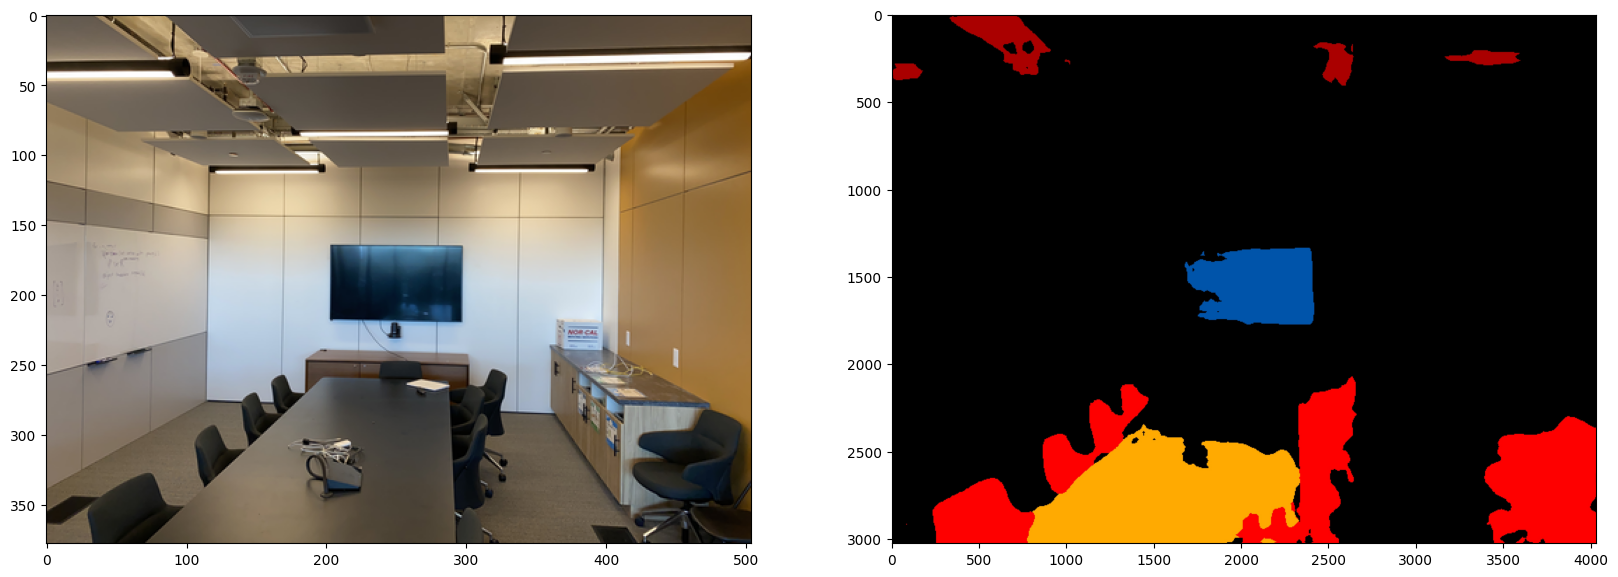

In [182]:
_, _, _, _ = fetch_data('room', 8, True)

## Poses and bounds

In [99]:
poses_bounds.shape

(41, 17)

In [100]:
poses_bounds[0]

array([-3.74575471e-03,  9.91971325e-01, -1.26407514e-01, -5.63453903e+00,
        3.02400000e+03,  9.98013889e-01, -4.24061671e-03, -6.28513700e-02,
       -3.55678573e+00,  4.03200000e+03, -6.28828025e-02, -1.26391880e-01,
       -9.89985276e-01,  1.72121178e-01,  3.07063827e+03,  1.74065463e+01,
        4.87814284e+01])

## Evaluate Generated images

In [199]:
score_list, diff_list = SSIM('room', 8)

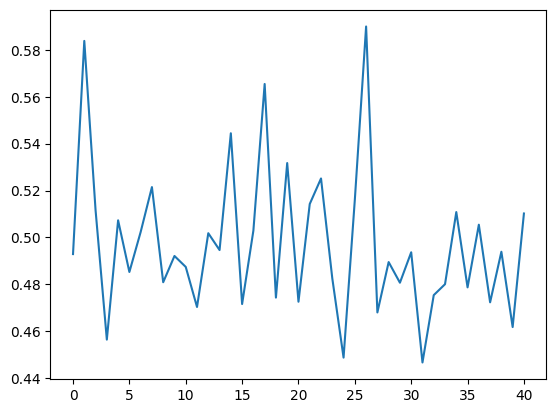

In [200]:
plt.plot(score_list)

In [201]:
np.asarray(score_list).mean()

0.49742236958075764

In [163]:
#To run script for FID scores
#python -m pytorch_fid D:\Mila\Adv_ML_proj\NeRF-Segmentation\nerf-pytorch\data\nerf_llff_data-20230309T215124Z-001\nerf_llff_data\room\images_8 D:\Mila\Adv_ML_proj\NeRF-Segmentation\nerf-pytorch\data\nerf_llff_data-20230309T215124Z-001\nerf_llff_data\room\rendered\room-llff --device cuda:0 --batch-size 1 --num-workers 0

In [180]:
g_i = cv2.imread("D:\\Mila\\Adv_ML_proj\\NeRF-Segmentation\\nerf-pytorch\\data\\nerf_llff_data-20230309T215124Z-001\\nerf_llff_data\\room\\rendered\\room-llff\\0000.png")
r_i = cv2.imread(r"D:\Mila\Adv_ML_proj\NeRF-Segmentation\nerf-pytorch\data\nerf_llff_data-20230309T215124Z-001\nerf_llff_data\room\images_8\DJI_20200226_143930_936.png")

g_i = cv2.cvtColor(g_i, cv2.COLOR_BGR2RGB)
r_i = cv2.cvtColor(r_i, cv2.COLOR_BGR2RGB)
score, diff = ssim(r_i, g_i, full=True, channel_axis=2)

In [181]:
score

0.5087290010232387